## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing the required libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
#Reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
print(nltk_data[:50])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('Great', 'NOUN'), ('Northern', 'NOUN'), ('Nekoosa', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('surged', 'VERB'), ('20', 'NUM'), ('1\\/8', 'NUM'), ('Tuesday', 'NOUN'), ('after', 'ADP'), ('Georgia-Pacific', 'NOUN'), ('launched', 'VERB'), ('a', 'DET'), ('$', '.'), ('3.18', 'NUM'), ('billion', 'NUM'), ('*U*', 'X'), ('offer', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('company', 'NOUN'), (',', '.'), ('dropped', 'VERB'), ('1', 'NUM'), ('3\\/8', 'NUM'), ('to', 'PRT'), ('61', 'NUM'), ('1\\/2', 'NUM'), ('in', 'ADP'), ('Big', 'NOUN'), ('Board', 'NOUN'), ('composite', 'NOUN'), ('trading', 'NOUN'), ('of', 'ADP'), ('5.1', 'NUM'), ('million', 'NUM'), ('shares', 'NOUN'), ('.', '.')], [('A', 'DET'), ('free', 'ADJ'), ('market', 'NOUN'), ('with', 'ADP'), ('a', 'DET'), ('profit', 'NOUN'), ('motive', 'NOUN'), ('will', 'VERB'), ('attract', 'VERB'), ('each', 'DET'), ('investor', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('liquidity', 'NOUN'), ('and', 'CONJ'), ('risks', 'NOUN'), ('0', 

In [5]:
#Getting the list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95785

In [6]:
#Tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Great',
 'Northern',
 'Nekoosa',
 ',',
 'which',
 '*T*-1',
 'surged',
 '20',
 '1\\/8',
 'Tuesday']

In [7]:
#Vocabulary
V = set(tokens)
print(len(V))

12121


In [8]:
#Number of tags
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'X', 'CONJ', 'ADJ', 'PRT', 'ADP', 'NOUN', 'NUM', 'PRON', 'VERB', 'ADV', '.', 'DET'}


### Build the vanilla Viterbi based POS tagger

In [9]:
#Computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [10]:
#Compute word given tag - Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [11]:
#Compute tag given tag - tag2(t2) given tag1 (t1); i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [12]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix

array([[7.51903579e-02, 1.03109134e-02, 1.64974611e-02, 1.85596451e-01,
        1.44511417e-01, 6.28172606e-02, 2.69670039e-03, 5.45685291e-02,
        2.03045681e-01, 2.55393405e-02, 1.64340109e-01, 5.48857860e-02],
       [8.76788143e-03, 4.61467454e-04, 1.19058609e-01, 5.07614203e-03,
        5.26072904e-02, 3.45639139e-01, 4.10706028e-02, 5.90678342e-02,
        1.59667745e-01, 5.58375642e-02, 3.46100591e-02, 1.18135668e-01],
       [2.12520584e-02, 1.72981881e-02, 6.73805624e-02, 1.05436575e-02,
        7.66062587e-02, 6.99176252e-01, 2.07578260e-02, 6.58978592e-04,
        1.25205927e-02, 4.77759494e-03, 6.44151568e-02, 4.61285003e-03],
       [1.30123617e-02, 2.27716332e-03, 8.42550397e-02, 1.95185421e-03,
        2.11450886e-02, 2.49186724e-01, 5.66037744e-02, 1.75666884e-02,
        3.99804801e-01, 9.75927152e-03, 4.32661027e-02, 1.01171114e-01],
       [3.38458270e-02, 8.54153302e-04, 1.06021784e-01, 1.17446086e-03,
        1.66559890e-02, 3.22229326e-01, 6.28870353e-02, 6.85

In [13]:
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,X,CONJ,ADJ,PRT,ADP,NOUN,NUM,PRON,VERB,ADV,.,DET
X,0.075190,0.010311,0.016497,0.185596,0.144511,0.062817,0.002697,0.054569,0.203046,0.025539,0.164340,0.054886
CONJ,0.008768,0.000461,0.119059,0.005076,0.052607,0.345639,0.041071,0.059068,0.159668,0.055838,0.034610,0.118136
ADJ,0.021252,0.017298,0.067381,0.010544,0.076606,0.699176,0.020758,0.000659,0.012521,0.004778,0.064415,0.004613
PRT,0.013012,0.002277,0.084255,0.001952,0.021145,0.249187,0.056604,0.017567,0.399805,0.009759,0.043266,0.101171
ADP,0.033846,0.000854,0.106022,0.001174,0.016656,0.322229,0.062887,0.068546,0.008435,0.013239,0.040038,0.326073
NOUN,0.029136,0.042703,0.011967,0.043976,0.176560,0.265059,0.009203,0.004620,0.147170,0.016950,0.239561,0.013095
NUM,0.209639,0.013601,0.032229,0.027499,0.034891,0.351271,0.188054,0.001478,0.017741,0.002661,0.117682,0.003253
PRON,0.094745,0.004987,0.072114,0.011507,0.023015,0.209436,0.006904,0.007288,0.484081,0.034906,0.041427,0.009590
VERB,0.218392,0.005578,0.064998,0.031608,0.091958,0.110784,0.023319,0.035714,0.168268,0.080880,0.035017,0.133483
ADV,0.024072,0.007355,0.128051,0.014042,0.119692,0.031762,0.031428,0.015714,0.346372,0.079238,0.135741,0.066533


In [14]:
tags_df.loc['.', :]

X       0.026748
CONJ    0.058343
ADJ     0.044430
PRT     0.002513
ADP     0.089938
NOUN    0.222691
NUM     0.081231
PRON    0.066870
VERB    0.089130
ADV     0.051701
.       0.093349
DET     0.172965
Name: ., dtype: float32

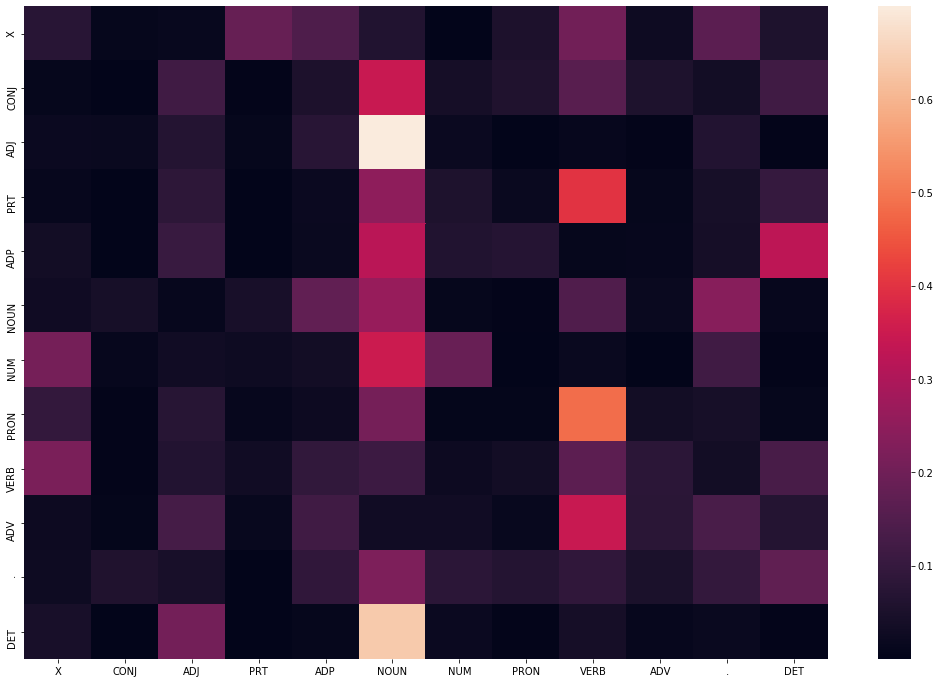

In [15]:
#Heatmap of tags matrix
#T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

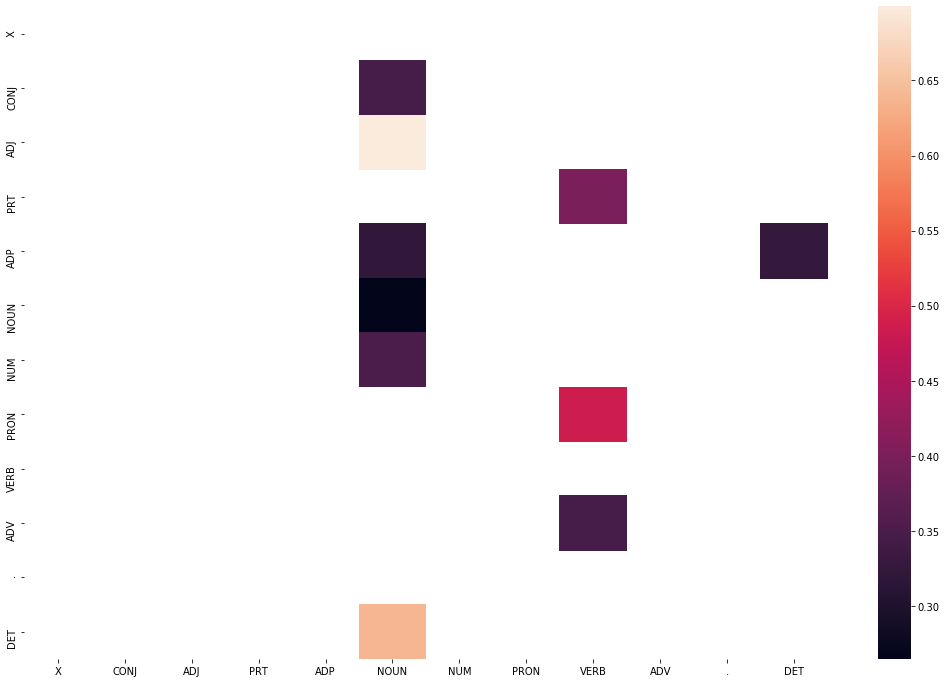

In [16]:
#Frequent tags
#Filtering the df to get P(t2, t1) > 0.25
tags_frequent = tags_df[tags_df>0.25]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [17]:
len(train_tagged_words)

95785

In [18]:
#Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [19]:
#Running on entire test dataset would take more than 3-4hrs. Let's test our Viterbi algorithm on a few sample sentences of test dataset
random.seed(1234)

#Choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

#List of sents
test_run = [test_set[i] for i in rndom]

#List of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

#List of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('He', 'PRON'),
  ('and', 'CONJ'),
  ('other', 'ADJ'),
  ('critics', 'NOUN'),
  ('say', 'VERB'),
  ('0', 'X'),
  ('such', 'ADJ'),
  ('coaching', 'NOUN'),
  ('aids', 'NOUN'),
  ('can', 'VERB'),
  ('defeat', 'VERB'),
  ('the', 'DET'),
  ('purpose', 'NOUN'),
  ('of', 'ADP'),
  ('standardized', 'ADJ'),
  ('tests', 'NOUN'),
  (',', '.'),
  ('which', 'DET'),
  ('*T*-104', 'X'),
  ('is', 'VERB'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('gauge', 'VERB'),
  ('learning', 'NOUN'),
  ('progress', 'NOUN'),
  ('.', '.')],
 [('Many', 'ADJ'),
  ('colleagues', 'NOUN'),
  ('are', 'VERB'),
  ('angry', 'ADJ'),
  ('at', 'ADP'),
  ('Mrs.', 'NOUN'),
  ('Yeargin', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('In', 'ADP'),
  ('Asia', 'NOUN'),
  (',', '.'),
  ('as', 'ADP'),
  ('in', 'ADP'),
  ('Europe', 'NOUN'),
  (',', '.'),
  ('a', 'DET'),
  ('new', 'ADJ'),
  ('order', 'NOUN'),
  ('is', 'VERB'),
  ('taking', 'VERB'),
  ('shape', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('Mr.', 'NOUN'),
  ('Baker', 'NOUN'),
  ('said',

In [20]:
#Tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  19.049398183822632
[('He', 'PRON'), ('and', 'CONJ'), ('other', 'ADJ'), ('critics', 'NOUN'), ('say', 'VERB'), ('0', 'X'), ('such', 'ADJ'), ('coaching', 'X'), ('aids', 'X'), ('can', 'VERB'), ('defeat', 'NOUN'), ('the', 'DET'), ('purpose', 'NOUN'), ('of', 'ADP'), ('standardized', 'ADJ'), ('tests', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-104', 'X'), ('is', 'VERB'), ('*', 'X'), ('to', 'PRT'), ('gauge', 'VERB'), ('learning', 'X'), ('progress', 'NOUN'), ('.', '.'), ('Many', 'ADJ'), ('colleagues', 'NOUN'), ('are', 'VERB'), ('angry', 'ADJ'), ('at', 'ADP'), ('Mrs.', 'NOUN'), ('Yeargin', 'NOUN'), ('.', '.'), ('``', '.'), ('In', 'ADP'), ('Asia', 'NOUN'), (',', '.'), ('as', 'ADP'), ('in', 'ADP'), ('Europe', 'NOUN'), (',', '.'), ('a', 'DET'), ('new', 'ADJ'), ('order', 'NOUN'), ('is', 'VERB'), ('taking', 'VERB'), ('shape', 'NOUN'), (',', '.'), ("''", '.'), ('Mr.', 'NOUN'), ('Baker', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), ('.', '.'), ('Card', 'X'), ('holder

In [21]:
#Accuracy for Vanilla Viterbi
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vannila_viterbi_accuracy = len(check)/len(tagged_seq)
vannila_viterbi_accuracy

0.9081632653061225

In [22]:
#Incorrectly tagged cases
incorrect_tagged_cases1 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases1

[[('such', 'ADJ'), (('coaching', 'X'), ('coaching', 'NOUN'))],
 [('coaching', 'NOUN'), (('aids', 'X'), ('aids', 'NOUN'))],
 [('can', 'VERB'), (('defeat', 'NOUN'), ('defeat', 'VERB'))],
 [('gauge', 'VERB'), (('learning', 'X'), ('learning', 'NOUN'))],
 [('.', '.'), (('Card', 'X'), ('Card', 'NOUN'))],
 [('a', 'DET'), (('sweepstakes', 'X'), ('sweepstakes', 'NOUN'))],
 [('as', 'ADP'), (('prizes', 'X'), ('prizes', 'NOUN'))],
 [('In', 'ADP'), (('early', 'ADJ'), ('early', 'ADV'))],
 [('$', '.'), (('374.19', 'X'), ('374.19', 'NUM'))]]

In [23]:
#Running on the sample text file
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
vannila_test_tagged_seq = tagged_seq

[('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.'), ('Android', 'X'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'X'), ('worldwide', 'X'), ('on', 'ADP'), ('smartphones', 'X'), ('since', 'ADP'), ('2011', 'X'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'X'), ('.', '.'), ('Google', 'X'), ('and', 'CONJ'), ('Twitter', 'X'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'X'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'X'), ("'s", 'PRT'), ('firehose', 'X'), ('.', '.'), ('Twitter', 'X'), ('is', 'VERB'), ('an', 'DET'), ('online', 'X'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', '

### Solve the problem of unknown words

##### Modification 1 : Rule Based Tagging with Viterbi

In [24]:
pattern = [
        (r'.*Twitter$', 'NOUN'), 
        (r'.*Android$', 'NOUN'),
        (r'.*Google$', 'NOUN'),
        (r'[-+]?\d*\.\d+|\d+', 'NUM'), #Number with floating values
        (r'.*es$', 'VERB'), 
        (r'.*ing$', 'VERB'), #Gerunds or continuous tense
        (r'.*ed$', 'VERB'),  #Past perfect tense
        (r'[A-Z ]+', 'NOUN'),  #All caps eg. FIFA, NASA, etc
        (r'.*', 'NOUN'), #Default value as NOUN
]

def rule_based_tagging(word, pattern):
    regexp_tagger = nltk.RegexpTagger(pattern)
    kv = regexp_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        print(word)
        print(v[1])
        return v[1]

In [25]:
#Viterbi Heuristic
def modified_Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

coaching
VERB
aids
NOUN
*T*-104
NOUN
learning
VERB
Card
NOUN
sweepstakes
VERB
prizes
VERB
374.19
NUM
Time taken in seconds:  18.711220502853394
[('He', 'PRON'), ('and', 'CONJ'), ('other', 'ADJ'), ('critics', 'NOUN'), ('say', 'VERB'), ('0', 'X'), ('such', 'ADJ'), ('coaching', 'VERB'), ('aids', 'NOUN'), ('can', 'VERB'), ('defeat', 'NOUN'), ('the', 'DET'), ('purpose', 'NOUN'), ('of', 'ADP'), ('standardized', 'ADJ'), ('tests', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-104', 'NOUN'), ('is', 'VERB'), ('*', 'X'), ('to', 'PRT'), ('gauge', 'VERB'), ('learning', 'VERB'), ('progress', 'NOUN'), ('.', '.'), ('Many', 'ADJ'), ('colleagues', 'NOUN'), ('are', 'VERB'), ('angry', 'ADJ'), ('at', 'ADP'), ('Mrs.', 'NOUN'), ('Yeargin', 'NOUN'), ('.', '.'), ('``', '.'), ('In', 'ADP'), ('Asia', 'NOUN'), (',', '.'), ('as', 'ADP'), ('in', 'ADP'), ('Europe', 'NOUN'), (',', '.'), ('a', 'DET'), ('new', 'ADJ'), ('order', 'NOUN'), ('is', 'VERB'), ('taking', 'VERB'), ('shape', 'NOUN'), (',', '.'), ("''", '.'), ('Mr

In [26]:
#Accuracy for Rule Based Tagging with Viterbi
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_modified_viterbi_accuracy = len(check)/len(tagged_seq)
print(rulebased_modified_viterbi_accuracy)

0.9285714285714286


In [27]:
#Incorrectly tagged cases
incorrect_tagged_cases2 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases2

[[('such', 'ADJ'), (('coaching', 'VERB'), ('coaching', 'NOUN'))],
 [('can', 'VERB'), (('defeat', 'NOUN'), ('defeat', 'VERB'))],
 [('which', 'DET'), (('*T*-104', 'NOUN'), ('*T*-104', 'X'))],
 [('gauge', 'VERB'), (('learning', 'VERB'), ('learning', 'NOUN'))],
 [('a', 'DET'), (('sweepstakes', 'VERB'), ('sweepstakes', 'NOUN'))],
 [('as', 'ADP'), (('prizes', 'VERB'), ('prizes', 'NOUN'))],
 [('In', 'ADP'), (('early', 'ADJ'), ('early', 'ADV'))]]

In [28]:
#Running on the sample text file
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_rule_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
rulebased_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

##### Modification 2 : Lexicon Based Tagging with Viterbi

In [29]:
def bigram_tagger(wording) :
    t0 = DefaultTagger('NOUN')
    t1 = UnigramTagger(train_set, backoff=t0)
    t2 = BigramTagger(train_set, backoff=t1)
    listvalue=t2.tag(nltk.word_tokenize(wording))
    return listvalue[0][1]

In [30]:
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger.evaluate(test_set)

0.9075853608668983

In [31]:
#Viterbi Heuristic
def modified_Viterbi_lexicon_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

coaching
VERB
aids
NOUN
*T*-104
NOUN
learning
VERB
Card
NOUN
sweepstakes
VERB
prizes
VERB
374.19
NUM
Time taken in seconds:  20.055511474609375
[('He', 'PRON'), ('and', 'CONJ'), ('other', 'ADJ'), ('critics', 'NOUN'), ('say', 'VERB'), ('0', 'X'), ('such', 'ADJ'), ('coaching', 'VERB'), ('aids', 'NOUN'), ('can', 'VERB'), ('defeat', 'NOUN'), ('the', 'DET'), ('purpose', 'NOUN'), ('of', 'ADP'), ('standardized', 'ADJ'), ('tests', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-104', 'NOUN'), ('is', 'VERB'), ('*', 'X'), ('to', 'PRT'), ('gauge', 'VERB'), ('learning', 'VERB'), ('progress', 'NOUN'), ('.', '.'), ('Many', 'ADJ'), ('colleagues', 'NOUN'), ('are', 'VERB'), ('angry', 'ADJ'), ('at', 'ADP'), ('Mrs.', 'NOUN'), ('Yeargin', 'NOUN'), ('.', '.'), ('``', '.'), ('In', 'ADP'), ('Asia', 'NOUN'), (',', '.'), ('as', 'ADP'), ('in', 'ADP'), ('Europe', 'NOUN'), (',', '.'), ('a', 'DET'), ('new', 'ADJ'), ('order', 'NOUN'), ('is', 'VERB'), ('taking', 'VERB'), ('shape', 'NOUN'), (',', '.'), ("''", '.'), ('Mr

In [32]:
#Accuracy for Lexicon Based Tagging with Viterbi
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
lexicon_based_viterbi_accuracy = len(check)/len(tagged_seq)
print(lexicon_based_viterbi_accuracy)

0.9285714285714286


In [33]:
#Incorrectly tagged cases
incorrect_tagged_cases3 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases3

[[('such', 'ADJ'), (('coaching', 'VERB'), ('coaching', 'NOUN'))],
 [('can', 'VERB'), (('defeat', 'NOUN'), ('defeat', 'VERB'))],
 [('which', 'DET'), (('*T*-104', 'NOUN'), ('*T*-104', 'X'))],
 [('gauge', 'VERB'), (('learning', 'VERB'), ('learning', 'NOUN'))],
 [('a', 'DET'), (('sweepstakes', 'VERB'), ('sweepstakes', 'NOUN'))],
 [('as', 'ADP'), (('prizes', 'VERB'), ('prizes', 'NOUN'))],
 [('In', 'ADP'), (('early', 'ADJ'), ('early', 'ADV'))]]

In [34]:
#Running on the sample text file
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
lexicon_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [35]:
print("Vannila Viterbi Accuracy: "+ str(vannila_viterbi_accuracy))
print("Rule Based Viterbi Accuracy: "+ str(rulebased_modified_viterbi_accuracy))
print("Lexicon Based Viterbi Accuracy: "+ str(lexicon_based_viterbi_accuracy))

Vannila Viterbi Accuracy: 0.9081632653061225
Rule Based Viterbi Accuracy: 0.9285714285714286
Lexicon Based Viterbi Accuracy: 0.9285714285714286


##### Lexicon Based Viterbi & Rule Based Viterbi 's accuracy are greater than Plain Vannila Viterbi's accuracy

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [36]:
#Vanilla vertirbi :
incorrect_tagged_cases1

[[('such', 'ADJ'), (('coaching', 'X'), ('coaching', 'NOUN'))],
 [('coaching', 'NOUN'), (('aids', 'X'), ('aids', 'NOUN'))],
 [('can', 'VERB'), (('defeat', 'NOUN'), ('defeat', 'VERB'))],
 [('gauge', 'VERB'), (('learning', 'X'), ('learning', 'NOUN'))],
 [('.', '.'), (('Card', 'X'), ('Card', 'NOUN'))],
 [('a', 'DET'), (('sweepstakes', 'X'), ('sweepstakes', 'NOUN'))],
 [('as', 'ADP'), (('prizes', 'X'), ('prizes', 'NOUN'))],
 [('In', 'ADP'), (('early', 'ADJ'), ('early', 'ADV'))],
 [('$', '.'), (('374.19', 'X'), ('374.19', 'NUM'))]]

In [37]:
#Rule Based viterbi :
incorrect_tagged_cases2

[[('such', 'ADJ'), (('coaching', 'VERB'), ('coaching', 'NOUN'))],
 [('can', 'VERB'), (('defeat', 'NOUN'), ('defeat', 'VERB'))],
 [('which', 'DET'), (('*T*-104', 'NOUN'), ('*T*-104', 'X'))],
 [('gauge', 'VERB'), (('learning', 'VERB'), ('learning', 'NOUN'))],
 [('a', 'DET'), (('sweepstakes', 'VERB'), ('sweepstakes', 'NOUN'))],
 [('as', 'ADP'), (('prizes', 'VERB'), ('prizes', 'NOUN'))],
 [('In', 'ADP'), (('early', 'ADJ'), ('early', 'ADV'))]]

In [38]:
#Lexicon Based viterbi :
incorrect_tagged_cases3

[[('such', 'ADJ'), (('coaching', 'VERB'), ('coaching', 'NOUN'))],
 [('can', 'VERB'), (('defeat', 'NOUN'), ('defeat', 'VERB'))],
 [('which', 'DET'), (('*T*-104', 'NOUN'), ('*T*-104', 'X'))],
 [('gauge', 'VERB'), (('learning', 'VERB'), ('learning', 'NOUN'))],
 [('a', 'DET'), (('sweepstakes', 'VERB'), ('sweepstakes', 'NOUN'))],
 [('as', 'ADP'), (('prizes', 'VERB'), ('prizes', 'NOUN'))],
 [('In', 'ADP'), (('early', 'ADJ'), ('early', 'ADV'))]]